from sklearn.preprocessing import RobustScaler
# ^^^ pyforest auto-imports - don't write above this line
___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 11<br><br>Multivariate Time Series Forecasting with RNN<br><br>(Manually)<br><h1>

# Dataset Info

Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction

- date time year-month-day hour:minute:second
- Appliances, energy use in Wh
- lights, energy use of light fixtures in the house in Wh
- T1, Temperature in kitchen area, in Celsius
- RH_1, Humidity in kitchen area, in %
- T2, Temperature in living room area, in Celsius
- RH_2, Humidity in living room area, in %
- T3, Temperature in laundry room area
- RH_3, Humidity in laundry room area, in %
- T4, Temperature in office room, in Celsius
- RH_4, Humidity in office room, in %
- T5, Temperature in bathroom, in Celsius
- RH_5, Humidity in bathroom, in %
- T6, Temperature outside the building (north side), in Celsius
- RH_6, Humidity outside the building (north side), in %
- T7, Temperature in ironing room , in Celsius
- RH_7, Humidity in ironing room, in %
- T8, Temperature in teenager room 2, in Celsius
- RH_8, Humidity in teenager room 2, in %
- T9, Temperature in parents room, in Celsius
- RH_9, Humidity in parents room, in %
- To, Temperature outside (from Chievres weather station), in Celsius
- Pressure (from Chievres weather station), in mm Hg
- RH_out, Humidity outside (from Chievres weather station), in %
- Wind speed (from Chievres weather station), in m/s
- Visibility (from Chievres weather station), in km
- Tdewpoint (from Chievres weather station), Â°C
- rv1, Random variable 1, nondimensional
- rv2, Random variable 2, nondimensional

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Recognizing and Understanding Data

In [2]:
df = pd.read_csv('energydata_complete.csv', index_col='date', parse_dates=True)

In [3]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890,47.597,19.200,44.790,19.790,44.730,19.000,45.567,17.167,55.200,7.027,84.257,17.200,41.627,18.200,48.900,17.033,45.530,6.600,733.500,92.000,7.000,63.000,5.300,13.275,13.275
2016-01-11 17:10:00,60,30,19.890,46.693,19.200,44.722,19.790,44.790,19.000,45.992,17.167,55.200,6.833,84.063,17.200,41.560,18.200,48.863,17.067,45.560,6.483,733.600,92.000,6.667,59.167,5.200,18.606,18.606
2016-01-11 17:20:00,50,30,19.890,46.300,19.200,44.627,19.790,44.933,18.927,45.890,17.167,55.090,6.560,83.157,17.200,41.433,18.200,48.730,17.000,45.500,6.367,733.700,92.000,6.333,55.333,5.100,28.643,28.643
2016-01-11 17:30:00,50,40,19.890,46.067,19.200,44.590,19.790,45.000,18.890,45.723,17.167,55.090,6.433,83.423,17.133,41.290,18.100,48.590,17.000,45.400,6.250,733.800,92.000,6.000,51.500,5.000,45.410,45.410
2016-01-11 17:40:00,60,40,19.890,46.333,19.200,44.530,19.790,45.000,18.890,45.530,17.200,55.090,6.367,84.893,17.200,41.230,18.100,48.590,17.000,45.400,6.133,733.900,92.000,5.667,47.667,4.900,10.084,10.084


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Appliances,19735.000,97.695,102.525,10.000,50.000,60.000,100.000,1080.000
lights,19735.000,3.802,7.936,0.000,0.000,0.000,0.000,70.000
T1,19735.000,21.687,1.606,16.790,20.760,21.600,22.600,26.260
RH_1,19735.000,40.260,3.979,27.023,37.333,39.657,43.067,63.360
T2,19735.000,20.341,2.193,16.100,18.790,20.000,21.500,29.857
RH_2,19735.000,40.420,4.070,20.463,37.900,40.500,43.260,56.027
T3,19735.000,22.268,2.006,17.200,20.790,22.100,23.290,29.236
RH_3,19735.000,39.243,3.255,28.767,36.900,38.530,41.760,50.163
T4,19735.000,20.855,2.043,15.100,19.530,20.667,22.100,26.200
RH_4,19735.000,39.027,4.341,27.660,35.530,38.400,42.157,51.090


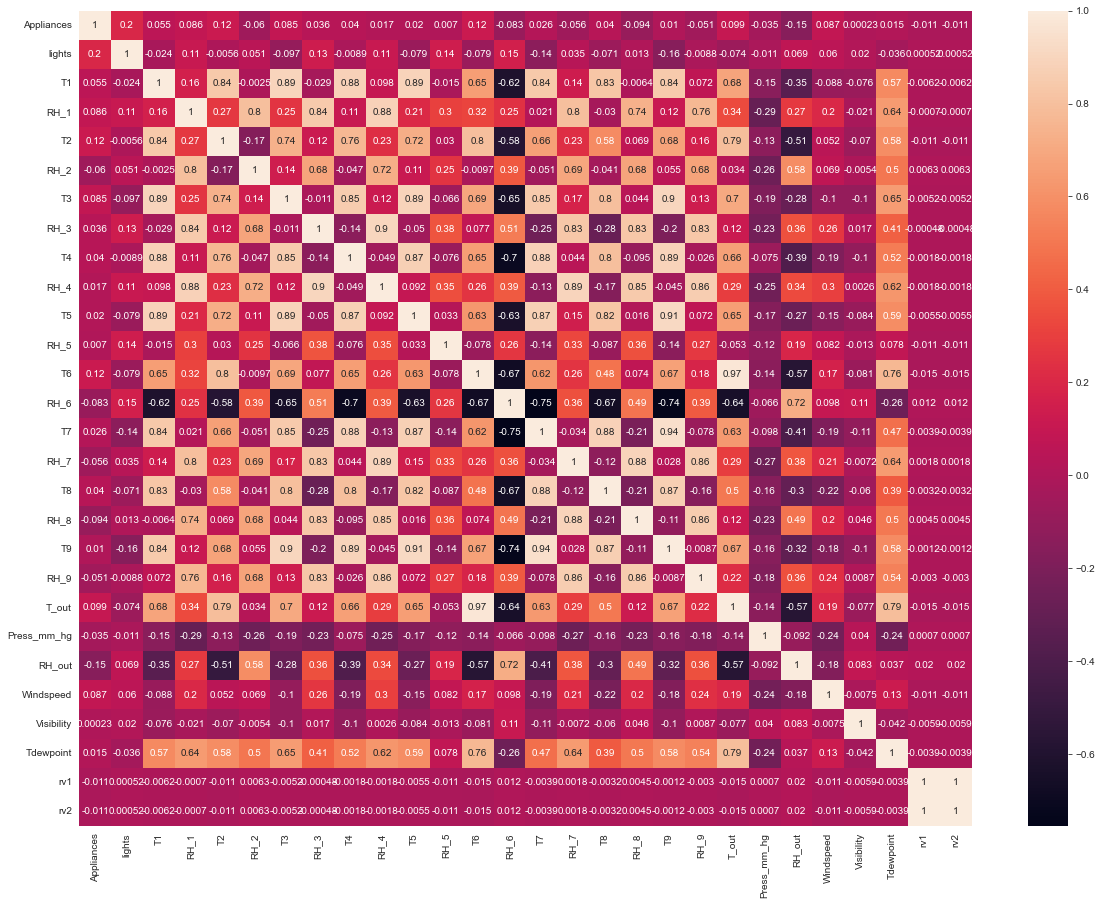

In [6]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

# Data Pre-Processing

## Feature Engineering
- Let's reduce the number of feature
- Let's resample the dataset by hours

In [7]:
df.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [8]:
df=df.rename(columns = {'T6':'T_outside', 'RH_6':'RH_outside'})
df["T_inside"] = (df["T1"] + df["T2"] + df["T3"] + df["T4"] + df["T5"] + df["T7"] + df["T8"] + df["T9"])/8
df["RH_inside"] = (df["RH_1"] + df["RH_2"] + df["RH_3"] + df["RH_4"] + df["RH_5"] + df["RH_7"] + df["RH_8"] + df["RH_9"])/8

In [9]:
drop_list = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
             'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'RH_out', 'rv1', 'rv2']
df.drop(drop_list, axis = 1, inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T_outside    19735 non-null  float64
 3   RH_outside   19735 non-null  float64
 4   Press_mm_hg  19735 non-null  float64
 5   Windspeed    19735 non-null  float64
 6   Visibility   19735 non-null  float64
 7   Tdewpoint    19735 non-null  float64
 8   T_inside     19735 non-null  float64
 9   RH_inside    19735 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.7 MB


In [11]:
df_a = df[["Appliances", "lights"]]
df_b = df.drop(["Appliances", "lights"], axis = 1)

In [12]:
df_a = df_a.resample("H").sum()
df_b = df_b.resample("H").mean()

In [13]:
df = pd.concat([df_a, df_b], axis =1)
df.head()

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,330,210,6.587,84.260,733.750,6.167,53.417,5.050,18.415,46.555
2016-01-11 18:00:00,1060,310,6.180,87.204,734.267,5.417,40.000,4.658,18.408,46.520
2016-01-11 19:00:00,1040,150,5.857,88.131,734.792,6.000,40.000,4.392,18.686,48.665
2016-01-11 20:00:00,750,210,5.469,86.934,735.283,6.000,40.000,4.017,18.941,50.356
2016-01-11 21:00:00,620,140,5.579,86.129,735.567,6.000,40.000,3.817,19.254,48.977


In [14]:
df.shape

(3290, 10)

Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [15]:
df = df.round(2)

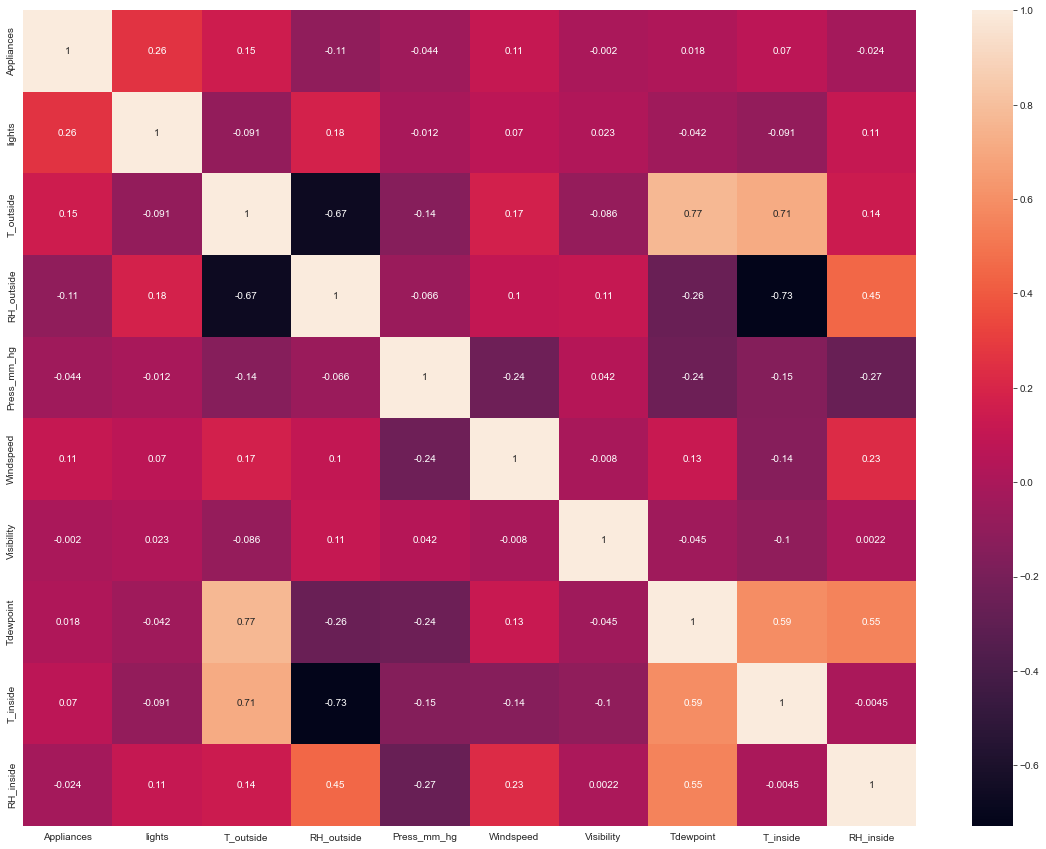

In [16]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True);

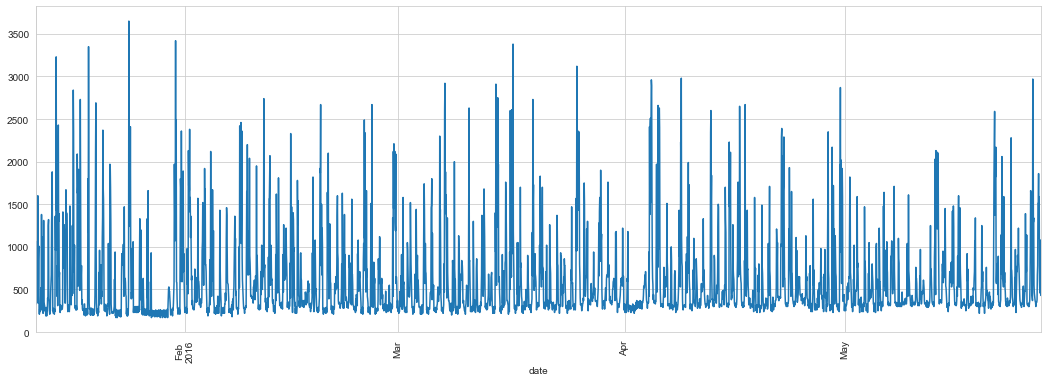

In [17]:
df['Appliances'].plot(figsize=(18,6))
plt.xticks(rotation=90);

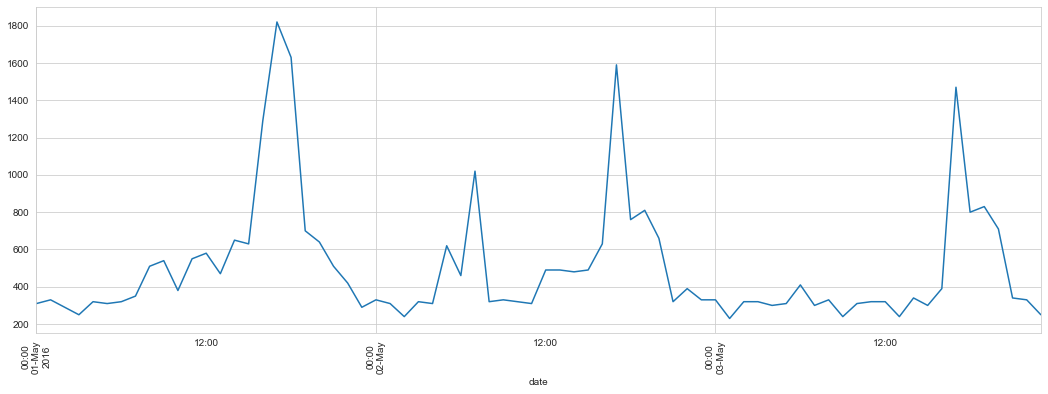

In [18]:
df['Appliances'].loc["2016-05-01 00:00:00" : "2016-05-03 23:00:00"].plot(figsize=(18,6))  # üç günlük
plt.xticks(rotation=90);

### Train Test Split

In [19]:
len(df)

3290

In [20]:
# How many rows per day?
24

24

In [21]:
test_days = 7

In [22]:
test_ind = test_days*24

In [23]:
test_ind

168

In [24]:
train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

In [25]:
train.shape, test.shape

((3122, 10), (168, 10))

### Scale Data

In [26]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [27]:
df.columns

Index(['Appliances', 'lights', 'T_outside', 'RH_outside', 'Press_mm_hg',
       'Windspeed', 'Visibility', 'Tdewpoint', 'T_inside', 'RH_inside'],
      dtype='object')

In [28]:
f_columns = df.columns[1:]

f_transformer = RobustScaler()
target_transformer = RobustScaler()

train.loc[:, f_columns] = f_transformer.fit_transform(train[f_columns])
train['Appliances'] = target_transformer.fit_transform(train[['Appliances']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns])
test['Appliances'] = target_transformer.transform(test[['Appliances']])

# ileride sadece 'Appliances' feature'ını inverse_transform yapacağımız için onu ayrı scale ettik

### Define a Function for Creating Time Steps 

In [ ]:
# bütün feature'lar kullanılarak sadece 'Appliances' değerini tahmin ettireceğimizden TimesSeriesGenerator kullanmayacağız
# (kullanırsak model bütün feature'lar için tahminde bulunur)
# bunun yerine fonksiyon tanımlayacağız

In [29]:
def create_dataset(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: target value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [30]:
time_steps = 24

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Appliances, time_steps)
X_test, y_test = create_dataset(test, test.Appliances, time_steps)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3098, 24, 10) (3098,)
(144, 24, 10) (144,)


In [31]:
y_test

array([ 0.77777778,  0.55555556,  1.22222222,  0.19444444,  1.44444444,
       -0.02777778, -0.08333333, -0.16666667, -0.13888889, -0.11111111,
       -0.19444444, -0.05555556,  0.02777778,  2.13888889,  0.86111111,
        2.33333333,  4.69444444,  1.08333333,  0.69444444,  0.75      ,
        0.58333333,  0.44444444,  3.38888889,  0.97222222,  0.58333333,
        0.91666667,  0.44444444,  0.27777778, -0.02777778, -0.05555556,
       -0.16666667, -0.05555556, -0.16666667, -0.19444444,  0.08333333,
       -0.02777778, -0.08333333, -0.16666667, -0.11111111, -0.16666667,
       -0.08333333,  0.        , -0.08333333, -0.05555556,  0.19444444,
        1.58333333,  5.30555556,  1.02777778,  0.97222222,  0.72222222,
        0.11111111,  0.02777778, -0.05555556, -0.19444444, -0.08333333,
       -0.11111111, -0.13888889, -0.13888889,  0.75      ,  0.16666667,
        1.66666667, -0.08333333, -0.38888889,  0.08333333,  0.66666667,
        1.11111111,  0.94444444,  1.47222222,  1.33333333,  1.33

## Model Building with LSTM

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
n_features = X_train.shape[2]  # 10

In [34]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, input_shape=(time_steps, n_features))))
# bidirectional ====> datayı hem düz (1' den 24'e), hem de tersten alacak (24'ten 1'e)

# model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [35]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [36]:
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=24, 
          validation_split=0.3,
          # shuffle=False,
          callbacks=[early_stop])

Epoch 1/30
91/91 [==============================] - 8s 33ms/step - loss: 1.4812 - val_loss: 1.0520
Epoch 2/30
91/91 [==============================] - 2s 21ms/step - loss: 1.2107 - val_loss: 0.9615
Epoch 3/30
91/91 [==============================] - 2s 21ms/step - loss: 1.1477 - val_loss: 1.0299
Epoch 4/30
91/91 [==============================] - 2s 21ms/step - loss: 1.1225 - val_loss: 0.8911
Epoch 5/30
91/91 [==============================] - 2s 21ms/step - loss: 1.0859 - val_loss: 0.8823
Epoch 6/30
91/91 [==============================] - 2s 21ms/step - loss: 1.0482 - val_loss: 0.8474
Epoch 7/30
91/91 [==============================] - 2s 21ms/step - loss: 1.0369 - val_loss: 0.9670
Epoch 8/30
91/91 [==============================] - 2s 22ms/step - loss: 0.9803 - val_loss: 0.9258
Epoch 9/30
91/91 [==============================] - 2s 21ms/step - loss: 0.9393 - val_loss: 1.0136
Epoch 10/30
91/91 [==============================] - 2s 22ms/step - loss: 0.9247 - val_loss: 0.8307
Epoch 11/

<AxesSubplot:>

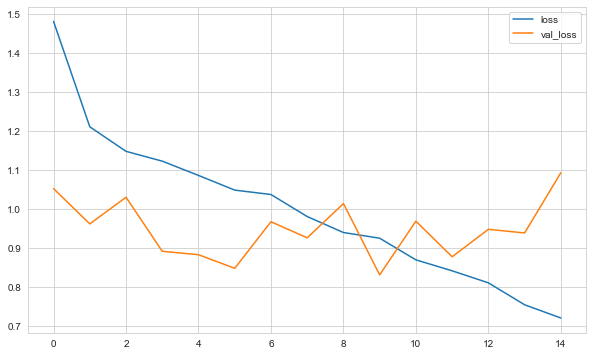

In [37]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [39]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

### First way : after each prediction, reel value will be used for next prediction¶

In [40]:
y_pred = model.predict(X_test)

In [41]:
y_pred[:20]

array([[1.8079976 ],
       [1.1610512 ],
       [0.7362601 ],
       [0.7904106 ],
       [0.67852056],
       [0.8973697 ],
       [0.78733724],
       [0.7332711 ],
       [0.68697524],
       [0.65929323],
       [0.6642656 ],
       [0.5860664 ],
       [0.5301995 ],
       [0.4195529 ],
       [0.837467  ],
       [1.0302066 ],
       [1.4101042 ],
       [2.3132017 ],
       [2.234644  ],
       [2.201287  ]], dtype=float32)

In [42]:
eval_metrics(y_test, y_pred)

r2_score: 0.13576358849098602 
mae: 0.8425447997869924 
mse: 1.5079926290659167 
rmse: 1.228003513458295


### Inverse Transformation and Compare

In [43]:
y_train_inv = target_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = target_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = target_transformer.inverse_transform(y_pred)

In [44]:
test_index = test.iloc[time_steps:].index

pred_test = pd.concat([pd.DataFrame(y_test_inv.reshape(-1, 1)),
                       pd.DataFrame(y_pred_inv)], axis = 1)
pred_test.columns=['test','prediction']
pred_test.index = test_index
pred_test

,test,prediction
date,,
2016-05-21 19:00:00,650.000,1020.879
2016-05-21 20:00:00,570.000,787.978
2016-05-21 21:00:00,810.000,635.054
2016-05-21 22:00:00,440.000,654.548
2016-05-21 23:00:00,890.000,614.267
...,...,...
2016-05-27 14:00:00,610.000,986.141
2016-05-27 15:00:00,460.000,964.971
2016-05-27 16:00:00,810.000,884.497


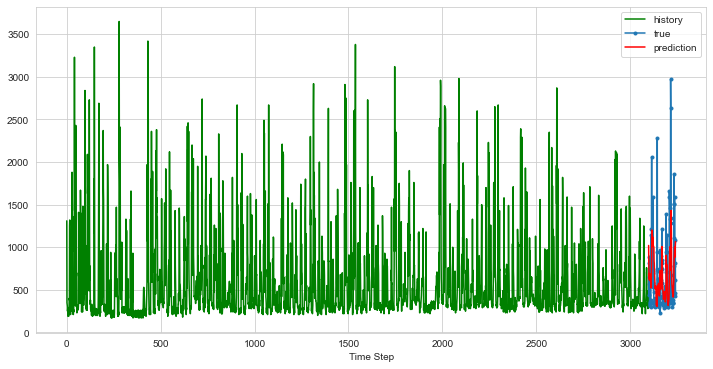

In [45]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.xlabel('Time Step')
plt.legend()
plt.show();

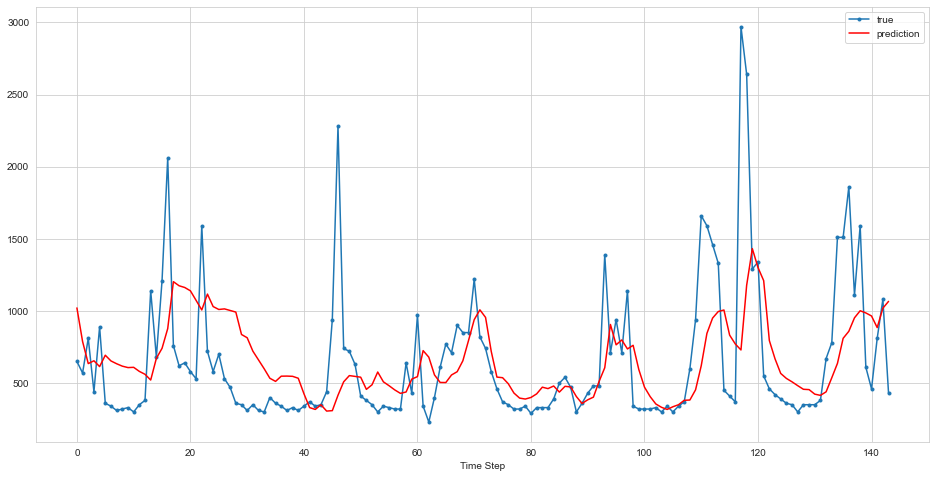

In [46]:
plt.figure(figsize=(16,8))
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.xlabel('Time Step')
plt.legend()
plt.show();

### Second way : after each prediction, result will be used for next prediction

In [47]:
test

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-05-20 19:00:00,0.056,0.000,1.852,-1.082,0.196,0.279,0.000,1.178,1.500,0.975
2016-05-20 20:00:00,0.139,0.000,1.296,-0.898,0.201,-0.115,0.000,1.151,1.423,0.790
2016-05-20 21:00:00,0.056,0.500,0.999,-0.598,0.209,-0.559,0.000,1.384,1.367,0.767
2016-05-20 22:00:00,-0.139,0.500,0.873,-0.435,0.220,-0.721,0.000,1.482,1.347,0.828
2016-05-20 23:00:00,-0.278,0.000,0.890,-0.289,0.208,-0.603,-0.561,1.631,1.321,0.889
...,...,...,...,...,...,...,...,...,...,...
2016-05-27 14:00:00,0.667,0.500,2.622,-1.090,-0.018,-0.441,-2.255,1.991,2.219,0.980
2016-05-27 15:00:00,0.250,0.000,2.722,-1.090,-0.030,-0.441,-2.224,1.949,2.214,0.896
2016-05-27 16:00:00,1.222,0.000,2.702,-1.090,-0.058,-0.324,-2.132,1.953,2.240,0.998


In [48]:
df_fake = test.iloc[:time_steps,1:]
df_fake

,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-05-20 19:00:00,0.000,1.852,-1.082,0.196,0.279,0.000,1.178,1.500,0.975
2016-05-20 20:00:00,0.000,1.296,-0.898,0.201,-0.115,0.000,1.151,1.423,0.790
2016-05-20 21:00:00,0.500,0.999,-0.598,0.209,-0.559,0.000,1.384,1.367,0.767
2016-05-20 22:00:00,0.500,0.873,-0.435,0.220,-0.721,0.000,1.482,1.347,0.828
2016-05-20 23:00:00,0.000,0.890,-0.289,0.208,-0.603,-0.561,1.631,1.321,0.889
2016-05-21 00:00:00,0.000,0.864,-0.193,0.180,-0.324,-1.398,1.829,1.301,0.941
2016-05-21 01:00:00,0.000,0.892,-0.131,0.143,-0.045,-0.857,1.833,1.286,0.964
2016-05-21 02:00:00,0.000,0.852,-0.123,0.104,0.117,0.000,1.822,1.276,0.977
2016-05-21 03:00:00,0.000,0.773,-0.107,0.076,0.117,-0.561,1.799,1.265,0.987


In [49]:
reel = np.array(test.iloc[:time_steps,:1])
reel.reshape((1,-1))[0]

array([ 0.05555556,  0.13888889,  0.05555556, -0.13888889, -0.27777778,
       -0.22222222, -0.16666667, -0.08333333, -0.22222222, -0.08333333,
       -0.16666667, -0.02777778, -0.08333333,  2.44444444,  4.13888889,
        5.36111111,  6.16666667,  2.77777778,  4.69444444,  4.02777778,
        5.        ,  0.63888889,  0.55555556,  1.05555556])

In [50]:
df_fake.shape

(24, 9)

In [51]:
df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1])).shape

(24, 1, 9)

In [52]:
predictions_scaled = []

first_eval_batch = train.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, n_features))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(time_steps):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0])
    new = features[i][0].tolist()
    new.insert(0,current_pred[0][0])
    new = np.array(new).reshape(1,1,n_features)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis=1)

In [53]:
predictions_scaled

[array([0.36737487], dtype=float32),
 array([0.14096762], dtype=float32),
 array([-0.13725778], dtype=float32),
 array([-0.20837516], dtype=float32),
 array([-0.21670975], dtype=float32),
 array([-0.3566681], dtype=float32),
 array([-0.48651072], dtype=float32),
 array([-0.43528357], dtype=float32),
 array([-0.22671956], dtype=float32),
 array([-0.21672373], dtype=float32),
 array([-0.3717664], dtype=float32),
 array([-0.54484284], dtype=float32),
 array([-0.60231185], dtype=float32),
 array([-0.5809577], dtype=float32),
 array([-0.54421437], dtype=float32),
 array([-0.30652526], dtype=float32),
 array([-0.01046163], dtype=float32),
 array([0.49900192], dtype=float32),
 array([0.91530085], dtype=float32),
 array([1.1664431], dtype=float32),
 array([1.3789501], dtype=float32),
 array([1.5643831], dtype=float32),
 array([1.7046527], dtype=float32),
 array([1.6665007], dtype=float32)]

In [54]:
reel

array([[ 0.05555556],
       [ 0.13888889],
       [ 0.05555556],
       [-0.13888889],
       [-0.27777778],
       [-0.22222222],
       [-0.16666667],
       [-0.08333333],
       [-0.22222222],
       [-0.08333333],
       [-0.16666667],
       [-0.02777778],
       [-0.08333333],
       [ 2.44444444],
       [ 4.13888889],
       [ 5.36111111],
       [ 6.16666667],
       [ 2.77777778],
       [ 4.69444444],
       [ 4.02777778],
       [ 5.        ],
       [ 0.63888889],
       [ 0.55555556],
       [ 1.05555556]])

In [55]:
eval_metrics(reel, predictions_scaled)

r2_score: -0.3235813324187371 
mae: 1.5667353120925664 
mse: 6.069646726519316 
rmse: 2.4636653032665206


### Inverse Transformation and Compare

In [56]:
predictions = target_transformer.inverse_transform(predictions_scaled)
reel = target_transformer.inverse_transform(reel)

In [57]:
compare = pd.DataFrame(data = reel, index = test.index[:time_steps], columns = ["reel"])
compare["prediction"] = predictions
compare

,reel,prediction
date,,
2016-05-20 19:00:00,390.000,502.255
2016-05-20 20:00:00,420.000,420.748
2016-05-20 21:00:00,390.000,320.587
2016-05-20 22:00:00,320.000,294.985
2016-05-20 23:00:00,270.000,291.984
2016-05-21 00:00:00,290.000,241.599
2016-05-21 01:00:00,310.000,194.856
2016-05-21 02:00:00,340.000,213.298
2016-05-21 03:00:00,290.000,288.381


<AxesSubplot:xlabel='date'>

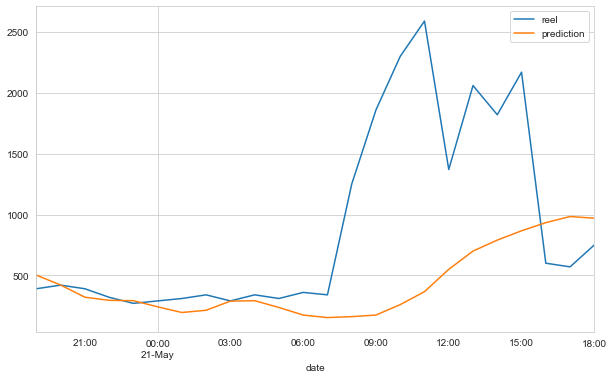

In [58]:
compare.plot()

## Retrain and Forecasting with Full Data

### Scale full data

In [59]:
df_scaled = df.copy()

In [60]:
val_size = 24
val = df_scaled.iloc[-val_size:]
full = df_scaled.iloc[:-val_size]
print(len(full), len(val))

3266 24


In [61]:
f_columns = df_scaled.columns[1:]

f_transformer = RobustScaler()
target_transformer = RobustScaler()

full.loc[:, f_columns] = f_transformer.fit_transform(full[f_columns]) # (full[f_columns].to_numpy())
full['Appliances'] = target_transformer.fit_transform(full[['Appliances']])

val.loc[:, f_columns] = f_transformer.fit_transform(val[f_columns]) # (val[f_columns].to_numpy())
val['Appliances'] = target_transformer.fit_transform(val[['Appliances']])

In [62]:
full

,Appliances,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,,
2016-01-11 17:00:00,-0.111,10.500,-0.087,0.547,-2.217,0.757,1.643,0.300,-1.038,1.046
2016-01-11 18:00:00,1.917,15.500,-0.141,0.603,-2.166,0.538,0.000,0.229,-1.043,1.041
2016-01-11 19:00:00,1.861,7.500,-0.184,0.620,-2.114,0.708,0.000,0.181,-0.909,1.415
2016-01-11 20:00:00,1.056,10.500,-0.236,0.597,-2.066,0.708,0.000,0.114,-0.789,1.709
2016-01-11 21:00:00,0.694,7.000,-0.221,0.582,-2.037,0.708,0.000,0.078,-0.641,1.469
...,...,...,...,...,...,...,...,...,...,...
2016-05-26 14:00:00,0.111,0.500,2.099,-1.029,0.057,-0.339,-1.499,0.991,1.660,0.074
2016-05-26 15:00:00,0.000,0.000,2.228,-1.029,0.038,-0.412,-1.000,1.106,1.646,0.039
2016-05-26 16:00:00,7.222,0.500,2.268,-1.029,0.014,-0.632,0.000,1.025,1.670,0.110


Let's devide dataset as "full" and "val". We can think about this "val" data as the weather forecast of next days.

### reshape to [samples, time_steps, n_features]

In [63]:
X, y = create_dataset(full, full.Appliances, time_steps)

print(X.shape, y.shape)

(3242, 24, 10) (3242,)


### Create Final model with full data

In [64]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, input_shape=(time_steps, n_features))))

#model.add(Dropout(rate=0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

In [65]:
model.fit(X, y, 
          epochs=15, 
          batch_size=24, 
          # shuffle=False
         )

Epoch 1/15
136/136 [==============================] - 8s 18ms/step - loss: 1.4179
Epoch 2/15
136/136 [==============================] - 3s 18ms/step - loss: 1.0919
Epoch 3/15
136/136 [==============================] - 2s 18ms/step - loss: 1.0667
Epoch 4/15
136/136 [==============================] - 2s 18ms/step - loss: 1.0358
Epoch 5/15
136/136 [==============================] - 2s 18ms/step - loss: 0.9972
Epoch 6/15
136/136 [==============================] - 2s 18ms/step - loss: 0.9716
Epoch 7/15
136/136 [==============================] - 2s 18ms/step - loss: 0.9282
Epoch 8/15
136/136 [==============================] - 2s 18ms/step - loss: 0.9352
Epoch 9/15
136/136 [==============================] - 2s 18ms/step - loss: 0.8901
Epoch 10/15
136/136 [==============================] - 2s 18ms/step - loss: 0.8576
Epoch 11/15
136/136 [==============================] - 2s 18ms/step - loss: 0.8432
Epoch 12/15
136/136 [==============================] - 2s 18ms/step - loss: 0.8065
Epoch 13/15
1

<AxesSubplot:>

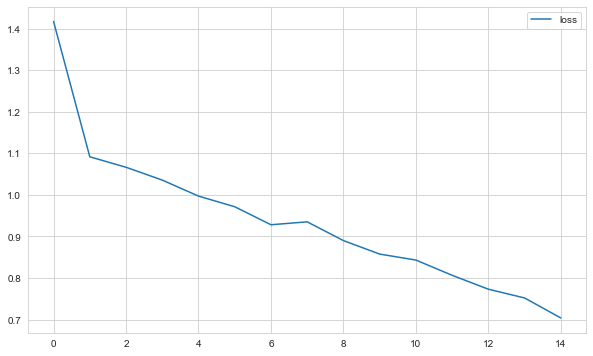

In [66]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### forecasting

In [67]:
df_fake = val.iloc[:,1:]
df_fake

,lights,T_outside,RH_outside,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T_inside,RH_inside
date,,,,,,,,,
2016-05-26 19:00:00,0.000,0.386,-0.215,-0.667,0.540,-0.504,-0.901,0.297,-2.770
2016-05-26 20:00:00,7.200,0.087,-0.197,-0.400,0.540,-0.526,-0.619,0.233,2.494
2016-05-26 21:00:00,6.400,-0.169,0.092,0.267,0.827,-0.316,-0.258,0.032,0.448
2016-05-26 22:00:00,9.600,-0.327,0.336,0.667,1.224,0.465,-0.049,-0.032,0.241
2016-05-26 23:00:00,8.800,-0.417,0.485,0.667,0.937,0.490,-0.161,-0.145,-0.034
2016-05-27 00:00:00,1.600,-0.468,0.672,0.489,0.253,0.456,-0.292,-0.208,0.126
2016-05-27 01:00:00,0.000,-0.486,0.757,0.044,-0.144,0.437,-0.341,-0.309,0.034
2016-05-27 02:00:00,0.000,-0.513,0.869,-0.133,-0.431,0.423,-0.351,-0.385,0.241
2016-05-27 03:00:00,0.000,-0.546,0.984,-0.289,0.027,0.294,-0.239,-0.461,0.356


In [68]:
reel = np.array(val.iloc[:,:1])
reel.reshape((1,-1))[0]

array([ 1.17192982,  0.06315789, -0.06315789, -0.11929825, -0.16140351,
       -0.20350877, -0.21754386, -0.2877193 , -0.21754386, -0.21754386,
       -0.21754386, -0.1754386 ,  0.23157895,  0.38596491,  1.41052632,
        1.41052632,  1.90175439,  0.84912281,  1.52280702,  0.14736842,
       -0.06315789,  0.42807018,  0.80701754, -0.10526316])

### First way : after each prediction, reel value will be use for next prediction

In [69]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = full.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, full.shape[1]))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0][0]
    
    # store prediction
    forecast.append(current_pred) 
    new = features[i][0].tolist()
    new.insert(0,reel[i][0])
    new = np.array(new).reshape(1,1,full.shape[1])
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis = 1)

In [70]:
eval_metrics(reel.reshape((1,-1))[0], forecast)

r2_score: -0.7726051953622801 
mae: 0.56446189922444 
mse: 0.7842721676577394 
rmse: 0.8855914225294526


In [71]:
forecast = target_transformer.inverse_transform(np.array(forecast).reshape(1,-1))
forecast

array([[1690.3419 , 1288.0068 ,  374.6164 ,  422.42462,  553.47363,
         568.39294,  392.74902,  270.5011 ,  218.30203,  303.02472,
         407.18982,  526.30273,  762.40405, 1301.7916 , 1622.7681 ,
        1756.0392 , 1330.4039 ,  947.375  ,  685.299  ,  738.6304 ,
         925.234  , 1840.9539 , 2709.129  , 2255.9893 ]], dtype=float32)

In [72]:
forecast_index = pd.date_range(start = '2016-05-26 19:00:00', periods = periods, freq = 'H')

In [73]:
forecast_df = pd.DataFrame(data = forecast.reshape(-1, 1), index = forecast_index, columns = ['Forecast'])

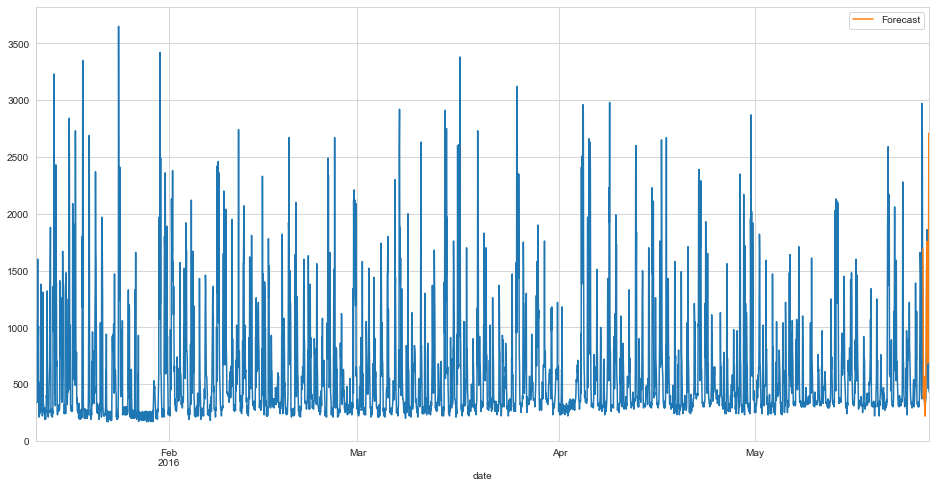

In [74]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(406699.0, 406770.0)

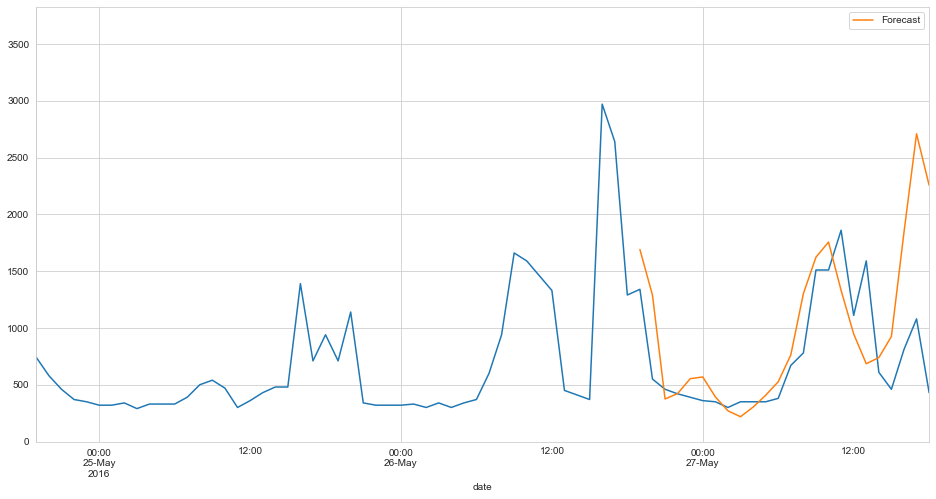

In [75]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2016-05-24 19:00:00', '2016-05-27 18:00:00')

### Second way : after each prediction, result will be use for next prediction

In [76]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = full.values[-time_steps:]
current_batch = first_eval_batch.reshape((1, time_steps, full.shape[1]))
features = df_fake.values.reshape((df_fake.shape[0], 1, df_fake.shape[1]))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0][0]
    
    # store prediction
    forecast.append(current_pred) 
    new = features[i][0].tolist()
    new.insert(0,current_pred)
    new = np.array(new).reshape(1,1,full.shape[1])
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], new, axis = 1)

In [77]:
eval_metrics(reel.reshape((1,-1))[0], forecast)

r2_score: -1.4623876501701045 
mae: 0.6288394365906279 
mse: 1.0894597990941042 
rmse: 1.0437719095157256


In [78]:
forecast = target_transformer.inverse_transform(np.array(forecast).reshape(1,-1))
forecast

array([[1690.3419 , 1407.4779 ,  627.51434,  476.51028,  562.11566,
         608.1406 ,  476.48752,  347.15912,  265.69263,  287.55334,
         345.58234,  458.2124 ,  721.1837 , 1295.9287 , 1837.0277 ,
        2018.6616 , 1451.7761 ,  875.7987 ,  604.21594,  498.82446,
         748.0825 , 1580.38   , 2724.912  , 3082.4617 ]], dtype=float32)

In [79]:
forecast_index = pd.date_range(start = '2016-05-26 19:00:00', periods = periods, freq = 'H')

In [80]:
forecast_df = pd.DataFrame(data = forecast.reshape(-1, 1), index = forecast_index, columns = ['Forecast'])

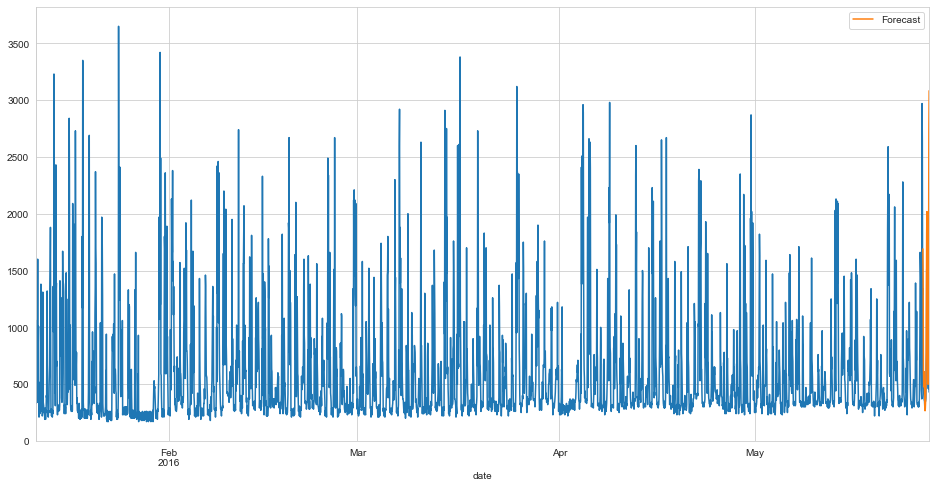

In [81]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(406699.0, 406770.0)

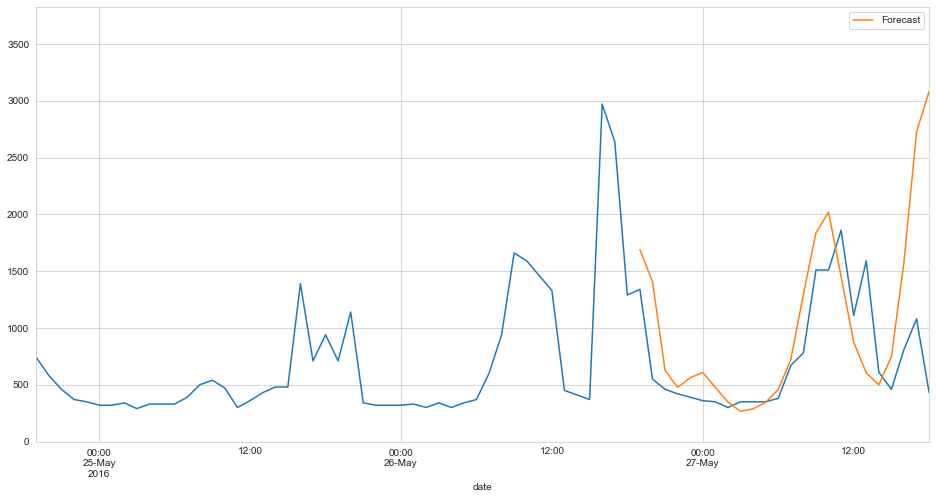

In [82]:
ax = df["Appliances"].plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2016-05-24 19:00:00', '2016-05-27 18:00:00')

<p style="text-align: center"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>